In [12]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation , Angle
import pandas as pd
import openpyxl
import os
# importing photutils to select a circular region of rad r around x, y
from photutils.aperture import CircularAperture, aperture_photometry

In [13]:
file = fits.open('66b5.fit')
file.info()

Filename: 66b5.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


In [14]:
file[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  765 /fastest changing axis                           
NAXIS2  =                  510 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2025-03-14T22:30:57' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =  0.80000000000000004 /Exposure time in seconds                        
EXPOSURE=  0.80000000000000004 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -8.5439465621954227 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

In [15]:
date_obs_ut=file[0].header['DATE-OBS']
exptime=file[0].header['EXPTIME']
ped_offset_corr=file[0].header['PEDESTAL']
gain = file[0].header['EGAIN']
print('date and time:',date_obs_ut)
print('exposure time in sec:',exptime)
print('pedestal offset correction:',ped_offset_corr)
print('gain in electron per adu',gain)

date and time: 2025-03-14T22:30:57
exposure time in sec: 0.8
pedestal offset correction: -100
gain in electron per adu 2.5799999237060547


In [16]:
# calculation of zenith angle
ra_hms = (17,19,48)      # Right Ascension in (hours, minutes, seconds)
dec_dms = (+10,49,59)   # Declination in (degrees, minutes, seconds)
latitude = 18.5592         # Observer's latitude in degrees 
longitude = 73.8253        # Observer's longitude in degrees
utc_time = date_obs_ut  # UTC time of observation

# Convert RA (hours, min, sec) to degrees
ra = Angle(f"{ra_hms[0]}h{ra_hms[1]}m{ra_hms[2]}s").degree  # RA in degrees

# Convert Dec (deg, min, sec) to decimal degrees
dec = Angle(f"{dec_dms[0]}d{dec_dms[1]}m{dec_dms[2]}s").degree  # Dec in degrees

# Convert Dec and Latitude to radians
dec = np.radians(dec)
latitude = np.radians(latitude)

# Compute Local Sidereal Time (LST)
time = Time(utc_time)
location = EarthLocation.from_geodetic(lon=longitude, lat=latitude)
lst = time.sidereal_time("apparent", longitude).degree  # LST in degrees

# Convert LST and RA to radians
lst_rad = np.radians(lst)
ra_rad = np.radians(ra)

# Compute Hour Angle (H = LST - RA) in radians
H = lst_rad - ra_rad

# Apply the cosine formula for the zenith angle
cos_Z = np.sin(latitude) * np.sin(dec) + np.cos(latitude) * np.cos(dec) * np.cos(H)

# Ensure cos_Z is within valid range [-1,1] for arccos
cos_Z = np.clip(cos_Z, -1, 1)

# Compute Zenith Angle (Z) in degrees
Z = np.degrees(np.arccos(cos_Z))

print(f"Zenith Angle: {Z:.2f} degrees")

Zenith Angle: 35.22 degrees


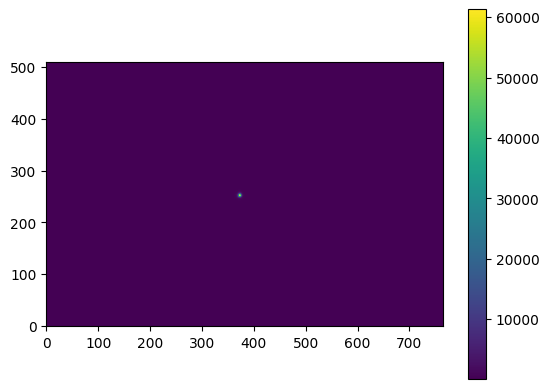

array([[123, 116, 106, ..., 117, 131, 121],
       [119, 119, 120, ..., 120, 125, 109],
       [117, 124, 112, ..., 112, 106, 104],
       ...,
       [108, 113, 113, ..., 105, 115, 110],
       [132, 124, 100, ..., 116, 119, 113],
       [127, 117, 122, ..., 115, 128, 138]], dtype=uint16)

In [17]:
image = file[0].data
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()
image

[[ 74.17499781  51.59999847  19.34999943 ...  54.82499838  99.97499704
   67.724998  ]
 [ 61.27499819  61.27499819  64.49999809 ...  64.49999809  80.62499762
   29.02499914]
 [ 54.82499838  77.39999771  38.69999886 ...  38.69999886  19.34999943
   12.89999962]
 ...
 [ 25.79999924  41.92499876  41.92499876 ...  16.12499952  48.37499857
   32.24999905]
 [103.19999695  77.39999771   0.         ...  51.59999847  61.27499819
   41.92499876]
 [ 87.07499743  54.82499838  70.9499979  ...  48.37499857  90.29999733
  122.54999638]]


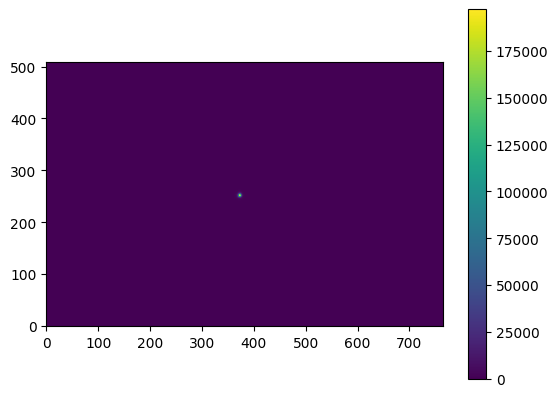

In [18]:
e_count= ((image*1.0)+ped_offset_corr)*gain #pedestal corrected electron counts
e_count= e_count/exptime #scaling for uniform exposure time = electron counts per unit time
print(e_count)
plt.imshow(e_count, origin='lower')
plt.colorbar()
plt.show()

In [19]:
# center of source
max_value = np.max(e_count) # max electron count value
max_index = np.unravel_index(np.argmax(e_count), e_count.shape) # indices of max counts
print(e_count.shape)
print(f"Maximum Value: {max_value}")
print(f"Indices of Maximum Value: {max_index}")  # Output as (row, column) (y,x)
# Interchange the indices (swap row and column)
max_index_swapped = (max_index[1], max_index[0])
print(f"Swapped Indices: {max_index_swapped}")  # Output as (x, y) for consistency in further calculations

(510, 765)
Maximum Value: 197447.39416122437
Indices of Maximum Value: (252, 373)
Swapped Indices: (373, 252)


counts of source plus backgound =  [ 594415.13295625 2029590.59446188 3545863.82994445 4637667.68682401
 5271156.53577913 5622819.96939249 5828463.55297898 5960748.85150558
 6051589.2564248  6117594.99608264 6168150.38773739 6207764.69011581
 6239830.87084424 6266411.65144127]


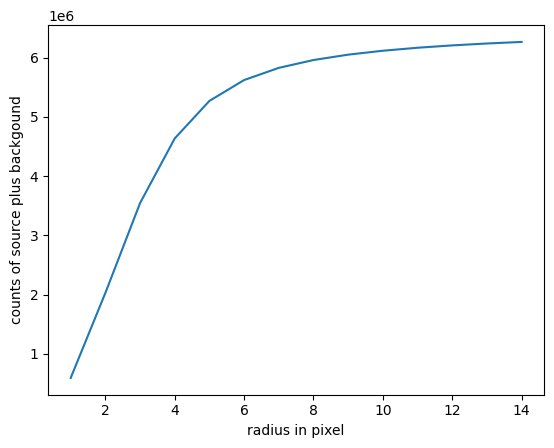

In [20]:
pos = max_index_swapped
# changing the radius and plotting counts vs px

electron_counts = [] 
radius= np.arange(1,15,1)

for i in radius:
    aper = CircularAperture(pos, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts.append(each_table['aperture_sum'].value)

electron_counts = (np.array(electron_counts)).flatten()
print('counts of source plus backgound = ',electron_counts)

plt.plot(radius, electron_counts)
plt.ylabel('counts of source plus backgound')
plt.xlabel('radius in pixel')
#plt.yscale('log')
plt.show()

counts of source =  [ 594256.23085076 2029030.51030135 3544532.89803405 4634906.17309448
 5266936.29411421 5616774.91560385 5820373.1689348  5950158.649919
 6038240.37780552 6100907.45739681 6147557.12443795 6183217.81749041
 6210843.17123898 6232703.8297937 ]


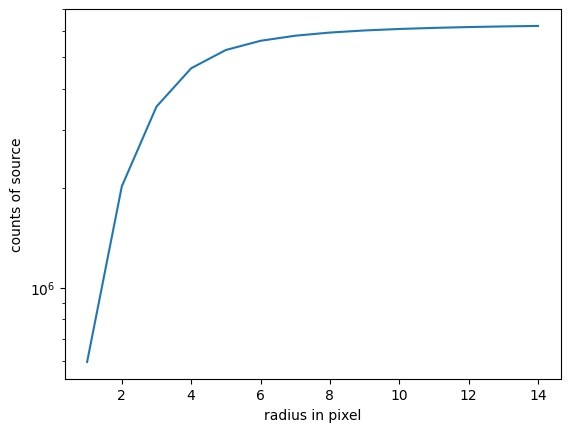

In [21]:
pos_bkg = (pos[0]+50,pos[1]+50)

electron_counts_bkg = [] 

for i in radius:
    aper = CircularAperture(pos_bkg, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts_bkg.append(each_table['aperture_sum'].value)

electron_counts_bkg = (np.array(electron_counts_bkg)).flatten() 
electron_counts_source= electron_counts-electron_counts_bkg
print('counts of source = ',electron_counts_source)

plt.plot(radius, electron_counts_source)
plt.ylabel('counts of source')
plt.xlabel('radius in pixel')
plt.yscale('log')
plt.show()

In [22]:
# Define region around src and bkg
r = 10 # radius in pixel
px= 9e-3 # length of pixel in mm
src_plus_bkg = electron_counts[r-1]
bkg = electron_counts_bkg[r-1]

fratio = 11.0
d = 14.0*25.4 # diameter of objective(14 inch) in mm
focal_length = d*fratio
p=206265/focal_length #plate scale in arcsec per mm
r_arcsec = r*px*p #radius in arcsec
sky_area = 3.14159265359*(r_arcsec**2)
print(sky_area)

flux_star = src_plus_bkg - bkg
flux_bkg = bkg
mag_star = 5.57 #standard
mag_bkg = mag_star - 2.5 * np.log10((flux_bkg) / flux_star)
sigma_sky_brightness = (2.5 / np.log(10)) * ((np.sqrt(flux_bkg)) ** (-1) + (np.sqrt(flux_star)) ** (-1))

sky_brightness = mag_bkg + 2.5 * np.log10(sky_area)

# Print outputs
print('Magnitude of star = ', mag_star)
print('Magnitude of background = ', mag_bkg)
print('Zenith angle = ',Z)  
print('Sky brightness = ', sky_brightness)
print('Propagated error in sky brightness = ', sigma_sky_brightness)

# Create or open an existing Excel file
file_path = 'output_data.xlsx'

# Check if file exists
if os.path.exists(file_path):
    # Load the existing workbook
    wb = openpyxl.load_workbook(file_path)
    sheet = wb.active
else:
    # Create a new workbook and sheet if it doesn't exist
    wb = openpyxl.Workbook()
    sheet = wb.active
    # Create headers if this is a new file
    sheet['A1'] = 'Row'
    sheet['B1'] = 'Magnitude of Star'
    sheet['C1'] = 'Magnitude of Background'
    sheet['D1'] = 'Zenith Angle'
    sheet['E1'] = 'Sky Brightness'
    sheet['F1'] = 'Error in Sky Brightness'

# Prompt user for the row to save the data
row_num = int(input("Enter the row number to save the data: "))

# Save the data in the selected row
sheet[f'A{row_num}'] = row_num
sheet[f'B{row_num}'] = mag_star
sheet[f'C{row_num}'] = mag_bkg
sheet[f'D{row_num}'] = Z 
sheet[f'E{row_num}'] = sky_brightness
sheet[f'F{row_num}'] = sigma_sky_brightness

# Save the workbook
wb.save(file_path)
print(f"Data has been saved in row {row_num} of the Excel file.")



70.75825253461372
Magnitude of star =  5.57
Magnitude of background =  11.977505379661366
Zenith angle =  35.220476075292744
Sky brightness =  16.601948126944894
Propagated error in sky brightness =  0.008844384406437977
Enter the row number to save the data: 19
Data has been saved in row 19 of the Excel file.
